# Project Description
The data used in this project will help to identify whether a person is going to recover from 
coronavirus symptoms or not based on some pre-defined standard symptoms. These symptoms are 
based on guidelines given by the World Health Organization (WHO).
This dataset has daily level information on the number of affected cases, deaths and recovery from 
2019 novel coronavirus. Please note that this is a time series data and so the number of cases on 
any given day is the cumulative number.
The data is available from 22 Jan, 2020. Data is in “data.csv”.
The dataset contains 14 major variables that will be having an impact on whether someone has 
recovered or not, the description of each variable are as follows,
1. Country: where the person resides
2. Location: which part in the Country
3. Age: Classification of the age group for each person, based on WHO Age Group Standard
4. Gender: Male or Female 
5. Visited_Wuhan: whether the person has visited Wuhan, China or not
6. From_Wuhan: whether the person is from Wuhan, China or not
7. Symptoms: there are six families of symptoms that are coded in six fields.
13. Time_before_symptoms_appear: 
14. Result: death (1) or recovered (0)

### First we will import the main libraries for the whole Project

In [26]:
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load and Visualize the Data... since it is of a high dimensional we will just see the table of data

In [27]:
names = ['location',"country","gender","age","vis_wuhan","from_wuhan","symptom1",
        "symptom2","symptom3","symptom4","symptom5","symptom6","diff_sym_hos","result"]
df = pd.read_csv("data.csv", header=None, skiprows=1, names=names)
print(df.loc[0:10]) #visualising first 11 rows

    location  country  gender   age  vis_wuhan  from_wuhan  symptom1  \
0        104        8       1  66.0          1           0        14   
1        101        8       0  56.0          0           1        14   
2        137        8       1  46.0          0           1        14   
3        116        8       0  60.0          1           0        14   
4        116        8       1  58.0          0           0        14   
5         23        8       0  44.0          0           1        14   
6        105        8       1  34.0          0           1        14   
7         13        8       1  37.0          1           0        14   
8         13        8       1  39.0          1           0        14   
9         13        8       1  56.0          1           0        14   
10        13        8       0  18.0          1           0        14   

    symptom2  symptom3  symptom4  symptom5  symptom6  diff_sym_hos  result  
0         31        19        12         3         1      

### divide the data into three partitions: training, validation, and testing
#### used the conventional 70% training 15% validation and 15% testing parititioning with randomness

In [28]:
from sklearn.model_selection import train_test_split
print(df.shape)
X = df.drop(columns=['result'])  #dropping the column of the target
Y = df['result']

randomState=44
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Split the data using train_test_split with randomness
XTrain, X_temp, YTrain, Y_temp = train_test_split(X, Y, test_size=1 - train_ratio, random_state=randomState)
XValidation, XTest, YValidation, YTest = train_test_split(
    X_temp, Y_temp, test_size=test_ratio / (validation_ratio + test_ratio), random_state=randomState)

(863, 14)


### Normalizing Data
I used StandardScaler for sklearn to normalize the data as you can see some of them are in 100s and some are just binary and some classifiers needs normalized data <br>

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
XTrain_scaled = scaler.fit_transform(XTrain)
XValidation_scaled = scaler.transform(XValidation)
xTest_scaled = scaler.transform(XTest)


## First Classification method is KNN

### Fitting,Choosing Parameters 

1- I tried k from 1 to sqrt of the number of training data why? because it is a common heuristic and works well in practice <br>
2- I used Validation data to choose the best K

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn import metrics

# Assuming X_train is your training data
num_training_samples = len(XTrain_scaled)
max_k = int(math.sqrt(num_training_samples))

best_k = None
best_f1 = 0.0
for k in range (1,max_k+1,2):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(XTrain_scaled,YTrain)
    y_pred_KNN = knn_classifier.predict(XValidation_scaled)

    f1_KNN = f1_score(YValidation, y_pred_KNN)

    if f1_KNN > best_f1:
        best_f1 = f1_KNN
        best_k = k
print("Best F1 Score",best_f1)
print("The K with the best F1 Score is ",best_k)

Best F1 Score 0.717948717948718
The K with the best F1 Score is  3


### Testing
Now, I will test using the test data using K=3

In [31]:
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(XTrain_scaled,YTrain)

y_test_KNN = knn_classifier.predict(xTest_scaled)
f1_Test_KNN = f1_score(YTest, y_test_KNN)
print("F1 Score for testing",f1_Test_KNN)

##14 0.6666 0.625
# 15 0.8   0.4
## 44 0.717   0.5

F1 Score for testing 0.6956521739130435


## Second Classification method Logistic Regression
1-Importing Logistic Regression from scikit-learn <Br> 
2-Initializing Logistic Regression model <br> 
- Maximum of 1000 iterations as lower number of iterations gave me total number of iterations reached limit <br>
- Solver='liblinear' because it works well with small and medium data for binary classes I tried others as well and the score was near <br>
- Penalty='l2' as it works with this kind of data well and I tried 'l1' gave the same result<br>

3-Getting the best F1 Score while trying different C <br>
4-Fitting LR to the best C <br>
5-Predicting and calculating F1 score on the testing data<br>

I used scaled data as it has a very little impact on logistic Regression
### finally some good F1 score!!

In [32]:
from sklearn.linear_model import LogisticRegression
best_C = None
best_LR_f1 = 0.0
for c in range(-1, 9):  
    HyperparamC = 0.0001 * (10 ** c)
    LR = LogisticRegression(C=HyperparamC,solver='liblinear',penalty='l2',max_iter=1000)
    LR.fit(XTrain_scaled,YTrain)
    y_pred_LR_Val = LR.predict(XValidation_scaled)

    f1_LR = f1_score(YValidation, y_pred_LR_Val)

    if f1_LR > best_LR_f1:
        best_LR_f1 = f1_LR
        best_C = HyperparamC
print("Best F1 Score on validation Data",best_LR_f1)
print("The C with the best F1 Score",best_C)


LR = LogisticRegression(C=best_C,solver='liblinear',max_iter=1000)
LR.fit(XTrain_scaled,YTrain)



y_pred_LR_Test = LR.predict(xTest_scaled)
f1_LR_Test =f1_score(YTest, y_pred_LR_Test)
print("F1 score for testing Data", f1_LR_Test)


Best F1 Score on validation Data 0.6875
The C with the best F1 Score 1.0
F1 score for testing Data 0.8181818181818182


## Third Classification method Naïve Bayes

1- Create a Gaussian Naïve Bayes classifier <br>
2- Try to get the smoothing Value that gets the best f1 score<br>
3- Make predictions on the testing data <br>
4- Evaluate the F1 score of the classifier <br>
<br>
Note: I didn't normalize the data as it doesn't matter in Naïve Bayes <br>

In [33]:
# Import necessary libraries
from sklearn.naive_bayes import GaussianNB

best_Naive_Smoothing_Value=0
smoothing_values = np.logspace(-12, 0, 13,base=10)
best_Naive_f1=0
for smoothing_value in smoothing_values:
    Naive = GaussianNB(var_smoothing=smoothing_value)
    Naive.fit(XTrain, YTrain)
    y_pred_Naive_Val = Naive.predict(XValidation)
    f1_Naive_Val =f1_score(YValidation, y_pred_Naive_Val)
    if f1_Naive_Val > best_Naive_f1:
        best_Naive_f1 = f1_Naive_Val
        best_Naive_Smoothing_Value = smoothing_value
print("Best F1 Score on validation Data",best_Naive_f1)
print("The smoothing value with the best F1 Score",best_Naive_Smoothing_Value)

    
Naive = GaussianNB(var_smoothing=best_Naive_Smoothing_Value)
Naive.fit(XTrain, YTrain)

y_Naive_pred = Naive.predict(XTest)
f1_Naive_Test =f1_score(YTest, y_Naive_pred)
print("F1 score for testing Data", f1_Naive_Test)

Best F1 Score on validation Data 0.5714285714285714
The smoothing value with the best F1 Score 0.01
F1 score for testing Data 0.7058823529411764


# PHASE I : Comparison
### 1- F1 Score

In [34]:
print(f"F1 score for KNN: {f1_Test_KNN:.2f}")
print(f"F1 score for Logistic Regression: {f1_LR_Test:.2f}")
print(f"F1 score for Naive Bayes: {f1_Naive_Test:.2f}")

F1 score for KNN: 0.70
F1 score for Logistic Regression: 0.82
F1 score for Naive Bayes: 0.71


### 2-Report for each

In [35]:
from sklearn.metrics import classification_report
report_KNN = classification_report(YTest,y_test_KNN)
print("KNN REPORT:")
print(report_KNN)
report_LR = classification_report(YTest,y_pred_LR_Test)
print("Logistic Regression REPORT:")
print(report_LR)
report_Naive = classification_report(YTest,y_Naive_pred)
print("Naive Bayes REPORT:")
print(report_Naive)

KNN REPORT:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       119
           1       0.67      0.73      0.70        11

    accuracy                           0.95       130
   macro avg       0.82      0.85      0.83       130
weighted avg       0.95      0.95      0.95       130

Logistic Regression REPORT:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       119
           1       0.82      0.82      0.82        11

    accuracy                           0.97       130
   macro avg       0.90      0.90      0.90       130
weighted avg       0.97      0.97      0.97       130

Naive Bayes REPORT:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       119
           1       1.00      0.55      0.71        11

    accuracy                           0.96       130
   macro avg       0.98      0.77      0.84       130
weighted avg  

#### Analysis based on the report:
The support can show us that most of the data is class 0 which is meaningful from the data as class 1 are the people died from covid 19 so they are probably less than who survived<br><br>
KNN: Good scores for class 0 while worse score for class 1, the overal accuracy is good,<br> it also has F1 score on the whole data 0.7
which is not very good but I think the bad scores for class 1 influenced that <br><br>
Logistic Regression: F1 score is 0.82 which is the best in these three classes, it has better scores for class 1 than the prior and Naive Bayes,<br>
It has the highest accuracy too<br><br>
Naive Bayes: It has good scores in general except for recall for class 1 which is the worst recall in all of them it means a high False Negative <br> it has overall F1 score of 0.71 which is near KNN F1 Score

### 3- ROC/AUC Curves

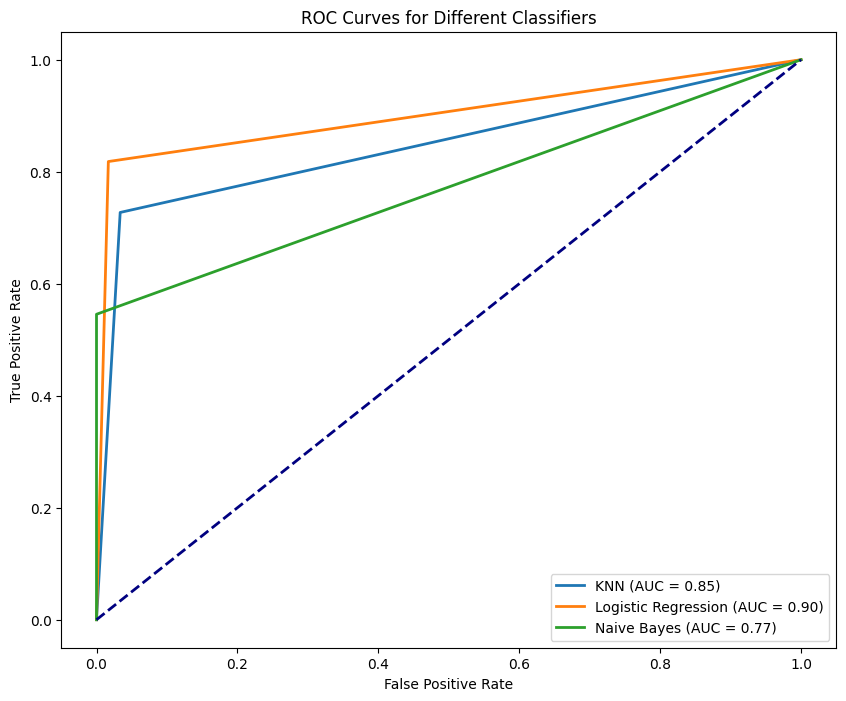

In [36]:
from sklearn.metrics import roc_curve, auc


fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(YTest, y_test_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)

fpr_LR, tpr_LR, thresholds_LR = roc_curve(YTest, y_pred_LR_Test)
roc_auc_LR = auc(fpr_LR, tpr_LR)

fpr_Naive, tpr_Naive, thresholds_Naive = roc_curve(YTest, y_Naive_pred)
roc_auc_Naive = auc(fpr_Naive, tpr_Naive)

# Plot all ROC curves on the same figure
plt.figure(figsize=(10, 8))

plt.plot(fpr_KNN, tpr_KNN, lw=2, label=f'KNN (AUC = {roc_auc_KNN:.2f})')

plt.plot(fpr_LR, tpr_LR, lw=2, label=f'Logistic Regression (AUC = {roc_auc_LR:.2f})')

plt.plot(fpr_Naive, tpr_Naive, lw=2, label=f'Naive Bayes (AUC = {roc_auc_Naive:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc='lower right')
plt.show()

#### Analysis based on the ROC/AUC curves:
Naive bayes has the smalled AUC while Logistic regression has the bigest AUC
we can see too that Logistic regression can give us around 0.82 TPR with only nearly 0 FPR 
Overall Logistic regression seems the best one of these three based on ROC/AUC curves

#### Conclusion:
Overall Logistic Regression seems to be the best out of the three with the highest AUC and F1 Score, with high precision and recall too and no drop in metric on account of another

## Fourth Classification Method Decision Trees
1- importing Decision Tree Classifier, GridSearch Cross Validation and Stratified K-fold<br>
2- I am using Cross Validation as there alot of parameters so I can not use a for loop to try them <br>
3- Stratified K-fold as it is better in imbalanced datasets, where some classes may have significantly fewer samples than others <br>
4- Using pd.concat as np.concatenate produces a warning it does not affect the result anyways <br>
5- Combining training and validation data <br>
6- Defining parameter grid with some parameter values to be tried <br>
7- Defining Stratified K-fold <br>
8- Fitting and printing F1 score and best parameters' values <br>
9- Testing and printing F1 score for testing Data <br>

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


XCombined = pd.concat([XTrain, XValidation], axis=0)
YCombined = pd.concat([YTrain, YValidation], axis=0)


param_tree_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 8, 10, 15],
    'max_leaf_nodes': [None, 5, 10, 20],
    'min_impurity_decrease': [0.0, 0.1, 0.2]
}

stratified_tree_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


tree_clf = DecisionTreeClassifier()

grid_tree_search = GridSearchCV(tree_clf, param_tree_grid, cv=stratified_tree_kfold, scoring='f1')
grid_tree_search.fit(XCombined, YCombined)


print("Best Parameters' values:", grid_tree_search.best_params_)
print("Best F1 Score for Validation:", grid_tree_search.best_score_)


Y_tree_pred = grid_tree_search.predict(XTest)
f1_tree = f1_score(YTest, Y_tree_pred)
print("F1 Score for Testing Data:", f1_tree)


Best Parameters' values: {'criterion': 'entropy', 'max_depth': 40, 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
Best F1 Score for Validation: 0.8514250459909365
F1 Score for Testing Data: 0.8


## Fifth Classification Method Support Vector Machines

1- importing SVC<br>
2- I am using Cross Validation as there alot of parameters so I can not use a for loop to try them <br>
3- Stratified K-fold as it is better in imbalanced datasets, where some classes may have significantly fewer samples than others <br>
4- Using scaled values as SVM needs normalized values in some kernels<br>
6- Defining parameter grid with some parameter values to be tried <br>
7- Defining Stratified K-fold <br>
8- Fitting and printing F1 score and best parameters' values <br>
9- Testing and printing F1 score for testing Data <br>


In [38]:
from sklearn.svm import SVC


XCombinedScaled = np.concatenate([XTrain_scaled, XValidation_scaled], axis=0)

# Define the parameter grid to search
param_SVM_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4],
    'gamma': ['scale', 'auto', 0.1, 1],
    'coef0': [0.0, 0.1, 0.5],
}

# Create an SVM classifier
SVM_clf = SVC()

# Create StratifiedKFold object
stratified_SVM_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create GridSearchCV object with StratifiedKFold
grid_SVM_search = GridSearchCV(estimator=SVM_clf, param_grid=param_SVM_grid, cv=stratified_SVM_kfold, scoring='f1')

# Fit the model to the data
grid_SVM_search.fit(XCombinedScaled,YCombined)

# Print the best parameters and corresponding accuracy
print("Best Parameters' values: ", grid_SVM_search.best_params_)
print("Best F1 Score for Validation ",grid_SVM_search.best_score_)

Y_SVM_pred = grid_SVM_search.predict(xTest_scaled)
f1_SVM = f1_score(YTest, Y_SVM_pred)
print("F1 Score for Testing Data:", f1_SVM)


Best Parameters' values:  {'C': 10, 'coef0': 0.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1 Score for Validation  0.8932289055973268
F1 Score for Testing Data: 0.846153846153846


# PHASE II : Comparison
### 1- F1 Score

In [39]:
print(f"F1 score for KNN: {f1_Test_KNN:.2f}")
print(f"F1 score for Logistic Regression: {f1_LR_Test:.2f}")
print(f"F1 score for Naive Bayes: {f1_Naive_Test:.2f}")
print(f"F1 score for Decision Trees: {f1_tree:.2f}")
print(f"F1 score for SVM: {f1_SVM:.2f}")

F1 score for KNN: 0.70
F1 score for Logistic Regression: 0.82
F1 score for Naive Bayes: 0.71
F1 score for Decision Trees: 0.80
F1 score for SVM: 0.85


### 2-Report for each

In [40]:
report_KNN = classification_report(YTest,y_test_KNN)
print("KNN REPORT:")
print(report_KNN)
report_LR = classification_report(YTest,y_pred_LR_Test)
print("Logistic Regression REPORT:")
print(report_LR)
report_Naive = classification_report(YTest,y_Naive_pred)
print("Naive Bayes REPORT:")
print(report_Naive)
report_tree = classification_report(YTest,Y_tree_pred)
print("Decision Trees REPORT:")
print(report_tree)
report_SVM = classification_report(YTest,Y_SVM_pred)
print("SVM REPORT:")
print(report_SVM)

KNN REPORT:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       119
           1       0.67      0.73      0.70        11

    accuracy                           0.95       130
   macro avg       0.82      0.85      0.83       130
weighted avg       0.95      0.95      0.95       130

Logistic Regression REPORT:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       119
           1       0.82      0.82      0.82        11

    accuracy                           0.97       130
   macro avg       0.90      0.90      0.90       130
weighted avg       0.97      0.97      0.97       130

Naive Bayes REPORT:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       119
           1       1.00      0.55      0.71        11

    accuracy                           0.96       130
   macro avg       0.98      0.77      0.84       130
weighted avg  

#### Analysis based on the report:
we have analysed them before except for Decision Trees and SVM

Decision Trees: Overall its score are so good except for the lower precision in class 1<br>
SVM: same thing with svm low precision in class 1

but overall f1 scores are pretty good

### 3- ROC/AUC Curves

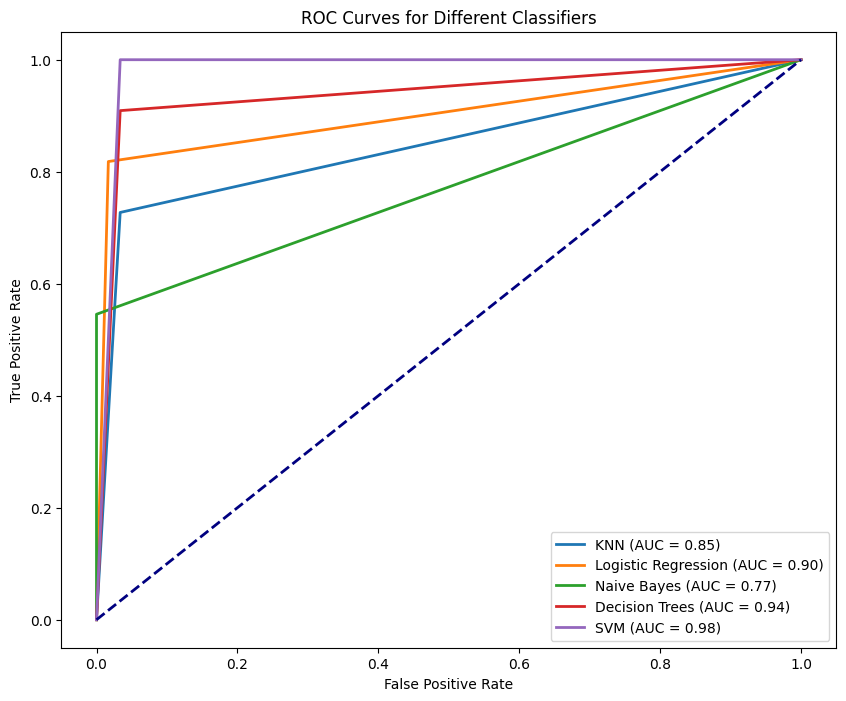

In [41]:
from sklearn.metrics import roc_curve, auc


fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(YTest, y_test_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)

fpr_LR, tpr_LR, thresholds_LR = roc_curve(YTest, y_pred_LR_Test)
roc_auc_LR = auc(fpr_LR, tpr_LR)

fpr_Naive, tpr_Naive, thresholds_Naive = roc_curve(YTest, y_Naive_pred)
roc_auc_Naive = auc(fpr_Naive, tpr_Naive)

fpr_tree, tpr_tree, thresholds_tree = roc_curve(YTest, Y_tree_pred)
roc_auc_tree = auc(fpr_tree, tpr_tree)

fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(YTest, Y_SVM_pred)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)

# Plot all ROC curves on the same figure
plt.figure(figsize=(10, 8))

plt.plot(fpr_KNN, tpr_KNN, lw=2, label=f'KNN (AUC = {roc_auc_KNN:.2f})')

plt.plot(fpr_LR, tpr_LR, lw=2, label=f'Logistic Regression (AUC = {roc_auc_LR:.2f})')

plt.plot(fpr_Naive, tpr_Naive, lw=2, label=f'Naive Bayes (AUC = {roc_auc_Naive:.2f})')

plt.plot(fpr_tree, tpr_tree, lw=2, label=f'Decision Trees (AUC = {roc_auc_tree:.2f})')

plt.plot(fpr_SVM, tpr_SVM, lw=2, label=f'SVM (AUC = {roc_auc_SVM:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc='lower right')
plt.show()

#### Analysis based on the ROC/AUC curves:
Naive bayes has the smalled AUC while SVM has the bigest AUC
we can see too that SVM can give us around 1 TPR with nearly 0 FPR <br>
Overall SVM seems to be the best one based on ROC/AUC curves

#### Conclusion:
SVM seems to be the best with the highest AUC and F1 Score and with high precision and recall too without drop in metrics on account of another <br>
Overall I would choose SVM